# The Annotated Transformer

**Focus**: understanding from positional encoding onwards.

**References**: 
- The Annotated Transformer, 2018 (https://nlp.seas.harvard.edu/2018/04/03/attention.html)

**Purpose**: 
- We want to improve translation quality of DL models as well as performance on NLP tasks.
- The goal of reducing sequential computation leads us to CNNs which compute hidden representaitons in parallel for all input and output positions. However, the number of operations required to relate signals from two arbitrary input or output positions grows in the distance between positions, linearly for ConvS2S and logrithmically for ByteNet.
- This makes it difficult to learn dependencies between distant positions.

**Approach**: 
- The Transformer, which leverages the attention mechanism, which reduces the number of operations required to relate signals from two arbitrary input or output positions to a constant number of operations.

**Result**: 
- A transformer model that is trained with parallelized computation across positions, enabling highly efficient training and SOTA results.

**Definitions**: 

**Notes**:


**FAQs**:
1. Q: I didn't really understand this part. Why is it 2\pi to 10000 * 2\pi?
<div style="text-align:center;">
  <img src="2025-09-01_PE.png" alt="diagram" style="width:100%;">
</div>

2. Q: Why was this important from their code?
```plaintext
# This was apparently important from their code?
# Initialize parameters with GLorot / fan_avg.
for p in model.parameters():
    if p.dim() > 1:
        nn.init(xavier_uniform(p))
```

**Action items**:
- Continue reading from "Training" section

In [1]:
# !pip install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl numpy matplotlib spacy torchtext seaborn 
!pip install numpy matplotlib spacy torchtext seaborn 
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Looking in indexes: https://download.pytorch.org/whl/cpu



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

In [3]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many other models
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator

    def forward(self, src, tgt, src_mask, tgt_mask):
        """Take in and process masked src and target sequences."""
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

In [4]:
class Generator(nn.Module):
    """Define standard linear + softmax generation step."""
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab) # logits (unnormalized logits for each token)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1) # log-probs

# Encoder and Decoder Stacks

## Encoder
The encoder is composed of a stack of N = 6 identical layers.

In [5]:
def clones(module, N):
    """Produce N identical layers."""
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [6]:
class Encoder(nn.Module):
    """Core encoder is a stack of N layers"""
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, mask):
        """Pass the input (and mask) through each layer in turn."""
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

In [7]:
class LayerNorm(nn.Module):
    """Construct a layernorm module."""
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2 # elementwise affine transformation

In [8]:
# assume d_model=512

class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm. Pre-Layernorm
    Note for code simplicity the norm is first as opposed to last. Also note: this is the classic method of a Pre-LayerNorm now which is empirically better than a Post-LayerNorm where
    def forward(self, x, sublayer):
        return self.norm(x + self.dropout(sublayer(x)))
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))

Each layer has two sub-layers. The first is a multi-head self-attention mechanism, and the second is a simple, position-wise fully connected feed-forward network.

In [9]:
class EncoderLayer(nn.Module):
    "encoder is made up of self-attn and feed forward (defined below)"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask)) # MHA
        return self.sublayer[1](x, self.feed_forward) # FF

## Decoder

The decoder is also composed of a stack of N = 6 identical layers.

In [10]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size) # d_model

    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

In [11]:
class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)

    def forward(self, x, memory, src_mask, tgt_mask):
        "Follow Figure 1 (right) for connections."
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

In [12]:
def subsequent_mask(size):
    "Mask out subsequent posiitons."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8') # sets everything below the 1 upper triangle to 0
    return torch.from_numpy(subsequent_mask) == 0

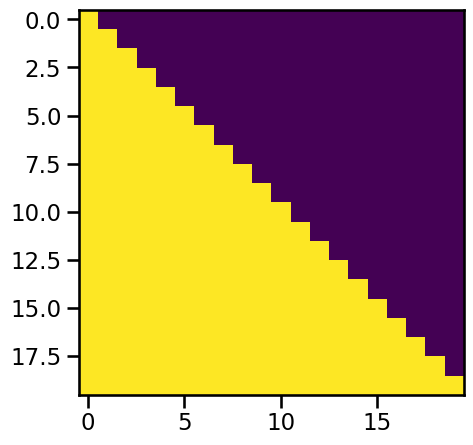

In [13]:
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])

## Attention

Scaled Dot-Product Attention
Input: queries and keys of dimension d_k, values of dimension d_v

In [14]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k) # affinities / compatibility function
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1) # weights
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

Multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions. 

Employ h = 8 parallel attention layers/heads

d_k = d_v = d_model / h = 64

512 / 8 = 64

In [15]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4) # Wq, Wk, Wv, Wo
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)

        # 1) Do all the linear projections in batch from d_model => h x d_k
        query, key, value = [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2) for l, x in zip(self.linears, (query, key, value))]

        # 2) Apply attention on all the projected vectors in batch
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)

        # 3) "Concat" using a view and apply a final linear.
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)

        return self.linears[-1](x)

## Position-wise Feed-Forward Networks
Q: Do you need a mask for this FFN? Or I guess not? 
- A: No, the FFN just transforms one token embedding into another token embedding. That's it.

Another way of describing this is as two convolutions with kernel size 1, projecting it from some input embedding dimension 1 to output embedding dimension 1, and then another one to project to output embeding dimension 2

Input and output dimension = d_model = 512, inner-layer has d_ff = 2048 (512 * 4)

In [16]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

## Embeddings and Softmax
norm = length / magnitude of a vector

Euclidean norm (L2 norm) = ||x||_2 = \sqrt(x_1^2 + x_2^2 + ... + x_n^2)

Remember, Mean(X) = E[X] and Var(X) = E[(X - E[X])^2]

When mean = 0, then Var(X) = E[X^2]

Expected Squared Norm = 

E[||e_tok||^2] = E[x_1^2] + E[x_2^2] + ... + E[x_d_model^2]

E[||e_tok||^2] = Var(x_1^2) + Var(x_2^2) + ... + Var(x_d_model^2)

E[||e_tok||^2] = 1

E[||e_tok||] = 1

Positional encodings also all have magnitude 1. 

In [17]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model) # lookup table where rows = vocabulary items size vocab and cols = embedding dimensions d_model. Note: nn.Embedding by default initializes each dimenion to have variance = 1/d_model s.t. expected vector norm = 1.
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model) # scaling to not have positional encodings dominate # the key reason why we scale is because many sublayers like attention product outputs with variance = 1 per dimension. Therefore, to get the embedding's per-dimension variance to be variance = 1 instead of 1/d_model, we need to multiply by \sqrt(self.d_model), assuming nn.Embedding initialized each dimension with variance 1/d_model so that the embedding vector norm = 1 # Therefore, we want all our vectors to have variance d_model.

## Positional Encoding

Positional encodings can be learned or fixed, we'll use fixed sine and consine functions of different frequencies: 

PE_{(pos,2i)} = sin(pos/10000**{2i/d_model})

PE_{(pos,2i+1)} = cos(pos/10000**{2i/d_model})



In [18]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model) # (N, D)
        position = torch.arange(0, max_len).unsqueeze(1) # (N, 1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)) # (D//2)

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0) # (1, N, D)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)],
                         requires_grad=False)
        return self.dropout(x)

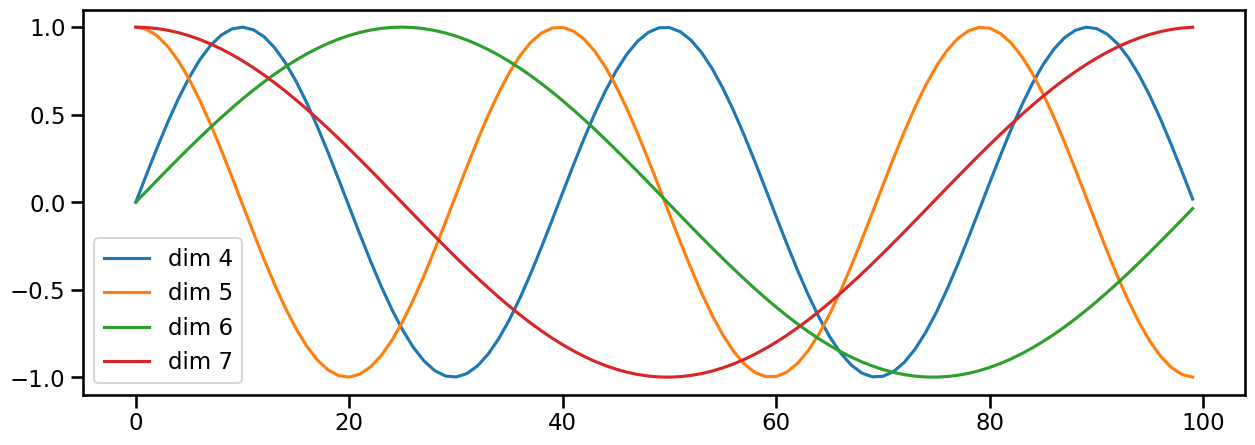

In [20]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(Variable(torch.zeros(1, 100, 20))) # (batch_size=1, seq_len=100, d_model=20)
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy()) # just looking at dimensions 4-7 positional encodings
plt.legend(["dim %d"%p for p in [4, 5, 6, 7]])

## Full Model
function that takes in hyperparameters and produces a full model

In [ ]:
def make_model(src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1):
    "Helper: Construct a model from hyperparamteters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab)
    )

    # This was apparently important from their code?
    # Initialize parameters with GLorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init(xavier_uniform(p))
    return model

In [ ]:
# Small example model.
tmp_model = make_model(10, 10, 2)